In [346]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [347]:
# Replace 'new_directory_path' with the path of the directory you want to set as the working directory
new_directory_path = r'/Users/seanbastians/Desktop/UNIVERSITY/4th Year/FIT3162 - DataSci Project 2/Project Files/fit3164_ds16/Datasets/Clean Datasets'

# Change the working directory
os.chdir(new_directory_path)

# Replace 'your_file.xls' with the actual path to your Excel file
excel_file_path = 'Forecasting-data.xlsx'

# Read the Excel file into a pandas DataFrame
df = pd.read_excel(excel_file_path)
df.set_index('Quarter')
df.index = pd.to_datetime(df.index)

fnab_df = df[['Quarter', 'FNAB']]
fnab_df = fnab_df.set_index('Quarter')
fnab_df.index = pd.to_datetime(fnab_df.index)
fnab_df = fnab_df[fnab_df.index >= '1990-03-01']
print(fnab_df.tail())

agcpi_df = df[['Quarter', 'AGCPI']]
agcpi_df = agcpi_df.set_index('Quarter')
agcpi_df.index = pd.to_datetime(agcpi_df.index)
agcpi_df = agcpi_df[agcpi_df.index >= '1990-03-01']
print(agcpi_df.tail())

            FNAB
Quarter         
2022-06-01   5.9
2022-09-01   9.0
2022-12-01   9.2
2023-03-01   8.0
2023-06-01   7.5
            AGCPI
Quarter          
2022-06-01    1.8
2022-09-01    1.8
2022-12-01    1.9
2023-03-01    1.4
2023-06-01    0.8


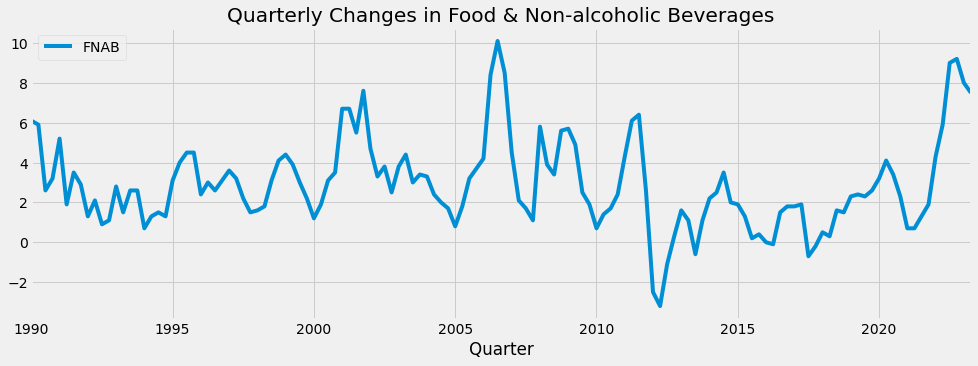

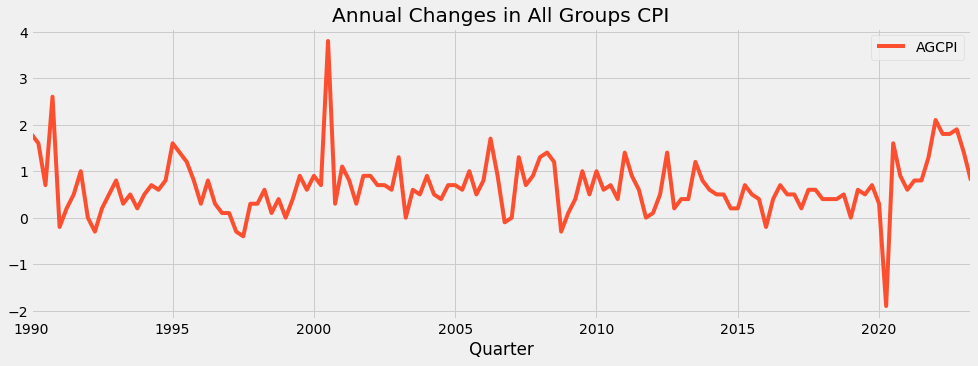

In [348]:
fnab_df.plot(style='-',
        figsize=(15, 5),
        color=color_pal[0],
        title='Quarterly Changes in Food & Non-alcoholic Beverages')
plt.show()

agcpi_df.plot(style='-',
        figsize=(15, 5),
        color=color_pal[1],
        title='Annual Changes in All Groups CPI')
plt.show()

# FNAB

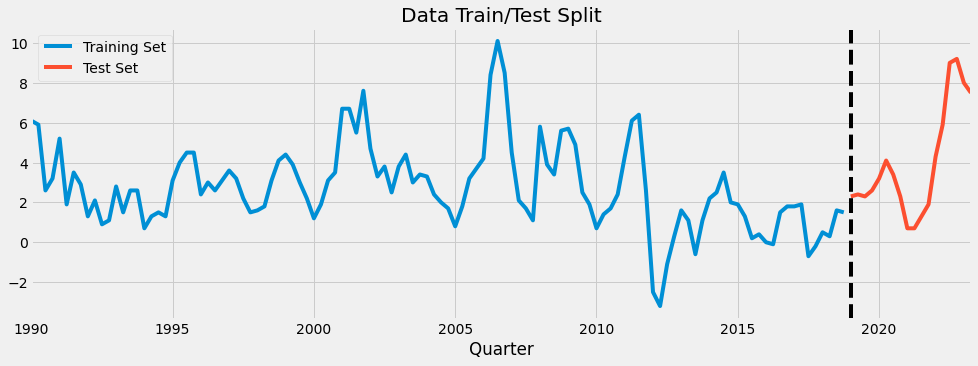

In [349]:
# FNAB Train / Test Split
train = fnab_df.loc[fnab_df.index < '01-06-2019']
test = fnab_df.loc[fnab_df.index >= '01-06-2019']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-06-2019', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

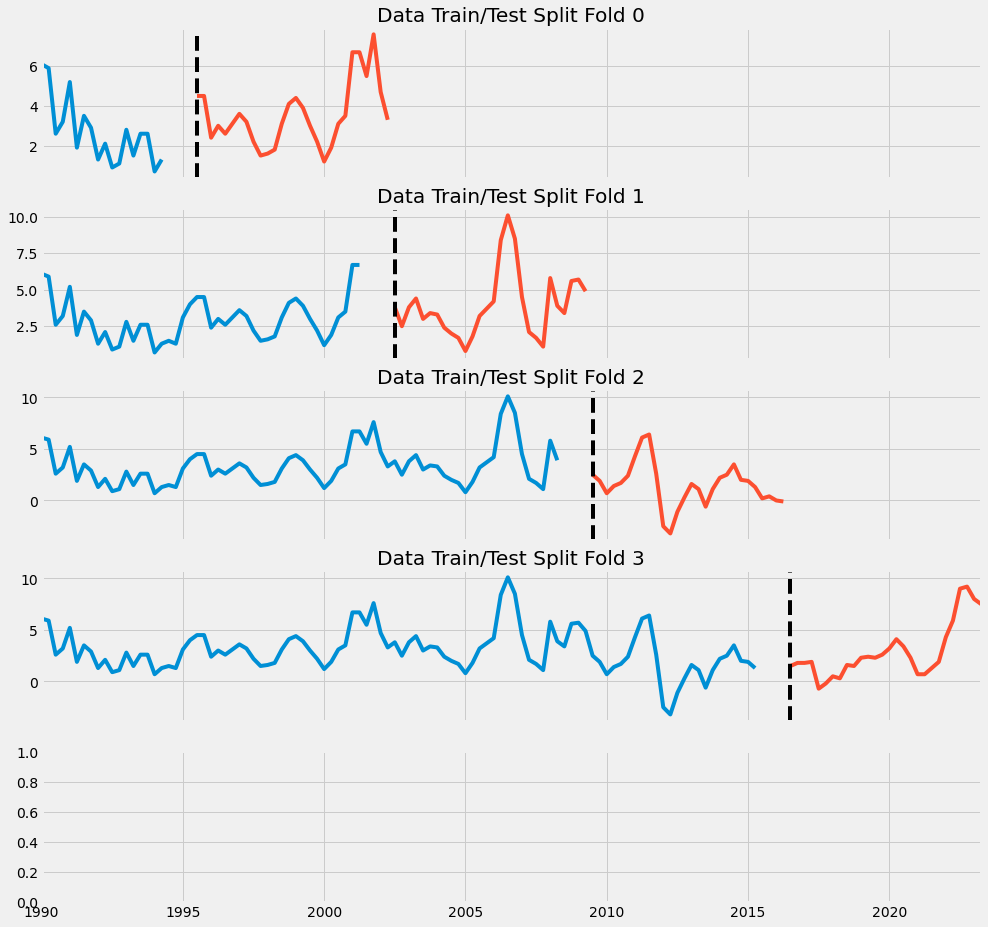

In [350]:
# Cross Validation using n-folds
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4, test_size=4*7, gap=4)
fnab_df = fnab_df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(fnab_df):
    train = fnab_df.iloc[train_idx]
    test = fnab_df.iloc[val_idx]
    train['FNAB'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['FNAB'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [351]:
# Feature Creation 
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

fnab_df = create_features(fnab_df)
fnab_df.head()


,FNAB,quarter,month,year
Quarter,,,,
1990-03-01,6.1,1,3,1990
1990-06-01,5.9,2,6,1990
1990-09-01,2.6,3,9,1990
1990-12-01,3.2,4,12,1990
1991-03-01,5.2,1,3,1991


In [352]:
# Add time lags
def add_lags(df):
    target_map = df['FNAB'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('365 days')).map(target_map)  # 1 year 
    df['lag2'] = (df.index - pd.Timedelta('1825 days')).map(target_map) # 5 years
    df['lag3'] = (df.index - pd.Timedelta('3650 days')).map(target_map) # 10 years     
    return df

fnab_df = add_lags(fnab_df)
fnab_df.tail()

,FNAB,quarter,month,year,lag1,lag2,lag3
Quarter,,,,,,,
2022-06-01,5.9,2,6,2022,0.7,NaN,NaN
2022-09-01,9.0,3,9,2022,1.3,NaN,NaN
2022-12-01,9.2,4,12,2022,1.9,NaN,NaN
2023-03-01,8.0,1,3,2023,4.3,NaN,NaN
2023-06-01,7.5,2,6,2023,5.9,NaN,NaN


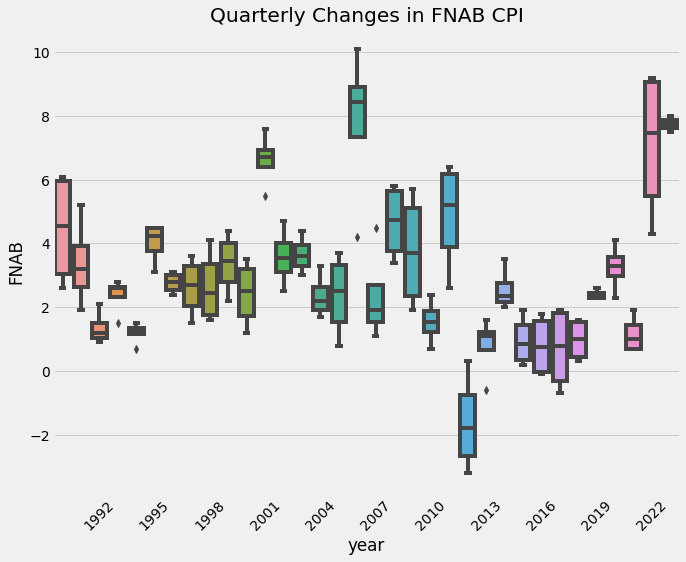

In [353]:
# Look at features on a yearly basis to see pattern 
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=fnab_df, x='year', y='FNAB')
ax.set_title('Quarterly Changes in FNAB CPI')
# Set tick positions and labels manually
unique_years = sorted(fnab_df['year'].unique())
xtick_positions = [i for i, year in enumerate(unique_years) if year % 3 == 0]
xtick_labels = [year for year in unique_years if year % 3 == 0]

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)
plt.show()

[0]	validation_0-rmse:2.67294	validation_1-rmse:3.41879


/opt/homebrew/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:18:01] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.30313	validation_1-rmse:3.05596
[200]	validation_0-rmse:0.67242	validation_1-rmse:2.95208
[300]	validation_0-rmse:0.38800	validation_1-rmse:2.90865
[400]	validation_0-rmse:0.25659	validation_1-rmse:2.88840
[500]	validation_0-rmse:0.19892	validation_1-rmse:2.88784
[509]	validation_0-rmse:0.19509	validation_1-rmse:2.88831
[0]	validation_0-rmse:2.84594	validation_1-rmse:4.04836


/opt/homebrew/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:18:03] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.40594	validation_1-rmse:2.38998
[200]	validation_0-rmse:0.86328	validation_1-rmse:2.19732
[217]	validation_0-rmse:0.81326	validation_1-rmse:2.22248
[0]	validation_0-rmse:3.38686	validation_1-rmse:2.26190


/opt/homebrew/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:18:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[74]	validation_0-rmse:2.03498	validation_1-rmse:2.45039
[0]	validation_0-rmse:3.24330	validation_1-rmse:3.55770


/opt/homebrew/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:18:04] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:1.86454	validation_1-rmse:2.99754
[200]	validation_0-rmse:1.36181	validation_1-rmse:2.96454
[300]	validation_0-rmse:1.15489	validation_1-rmse:2.91336
[400]	validation_0-rmse:1.04869	validation_1-rmse:2.90701
[414]	validation_0-rmse:1.03691	validation_1-rmse:2.91008


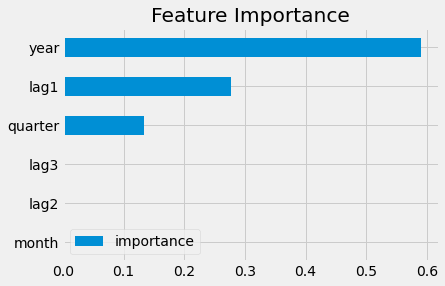

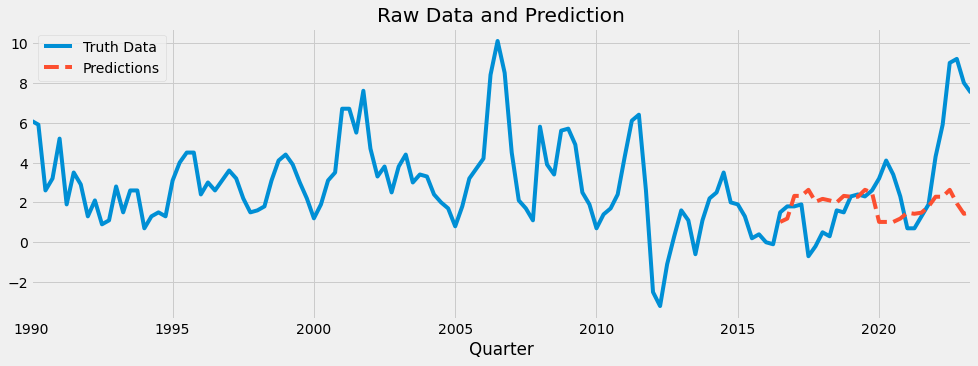

In [354]:
# create and run the XG Boost model

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4, test_size=4*7, gap=4)
fnab_df = fnab_df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(fnab_df):
    train = fnab_df.iloc[train_idx]
    test = fnab_df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'FNAB'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

# Feature Importance
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Raw Data & Prediction
test['prediction'] = reg.predict(X_test)
fnab_df = fnab_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = fnab_df[['FNAB']].plot(figsize=(15, 5))
fnab_df['prediction'].plot(ax=ax, style='--')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [355]:
# Look at fold scores 
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 2.4668
Fold scores:[2.8863644464025913, 2.1728661362520585, 1.9057120729462433, 2.902102354511509]


In [356]:
# Prediciting the future
# Retrain on all data
fnab_df = create_features(fnab_df)

FEATURES = ['quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'FNAB'

X_all = fnab_df[FEATURES]
y_all = fnab_df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.001)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)


[0]	validation_0-rmse:3.28248


/opt/homebrew/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:18:06] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:3.06244
[200]	validation_0-rmse:2.86763
[300]	validation_0-rmse:2.69541
[400]	validation_0-rmse:2.54326
[499]	validation_0-rmse:2.41023


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [357]:
# Create future dataframe
future = pd.date_range('2023-06-01','2033-06-01', freq='QS')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
fnab_df['isFuture'] = False
fnab_df_and_future = pd.concat([fnab_df, future_df])
fnab_df_and_future = create_features(fnab_df_and_future)
fnab_df_and_future = add_lags(fnab_df_and_future)

fnab_future_w_features = fnab_df_and_future.query('isFuture').copy()

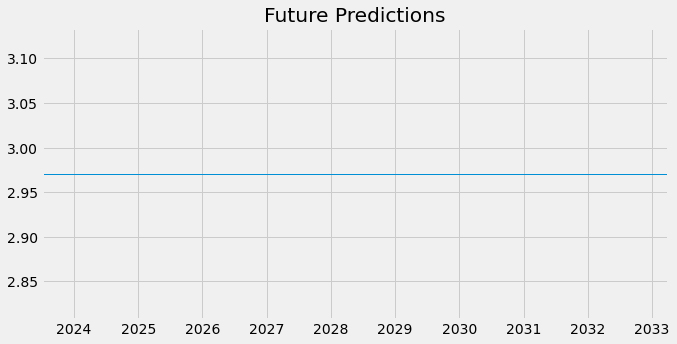

In [358]:
# Predict the future
fnab_future_w_features['pred'] = reg.predict(fnab_future_w_features[FEATURES])
fnab_future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[0],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()

# AGCPI

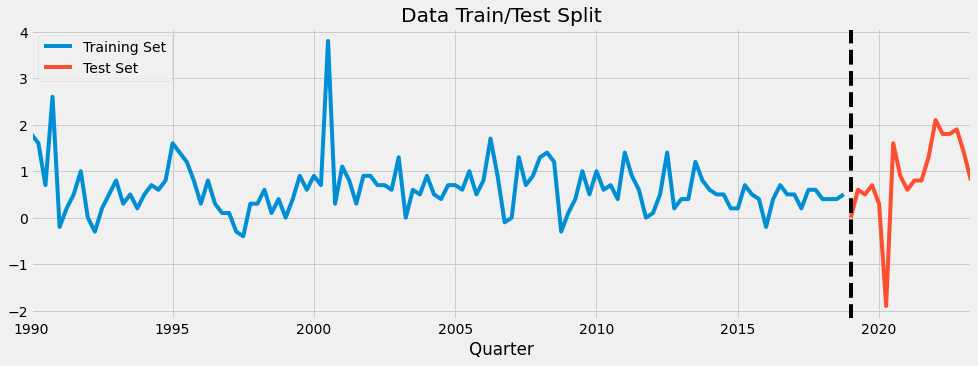

In [359]:
# FNAB Train / Test Split
train = agcpi_df.loc[agcpi_df.index < '01-06-2019']
test = agcpi_df.loc[agcpi_df.index >= '01-06-2019']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-06-2019', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

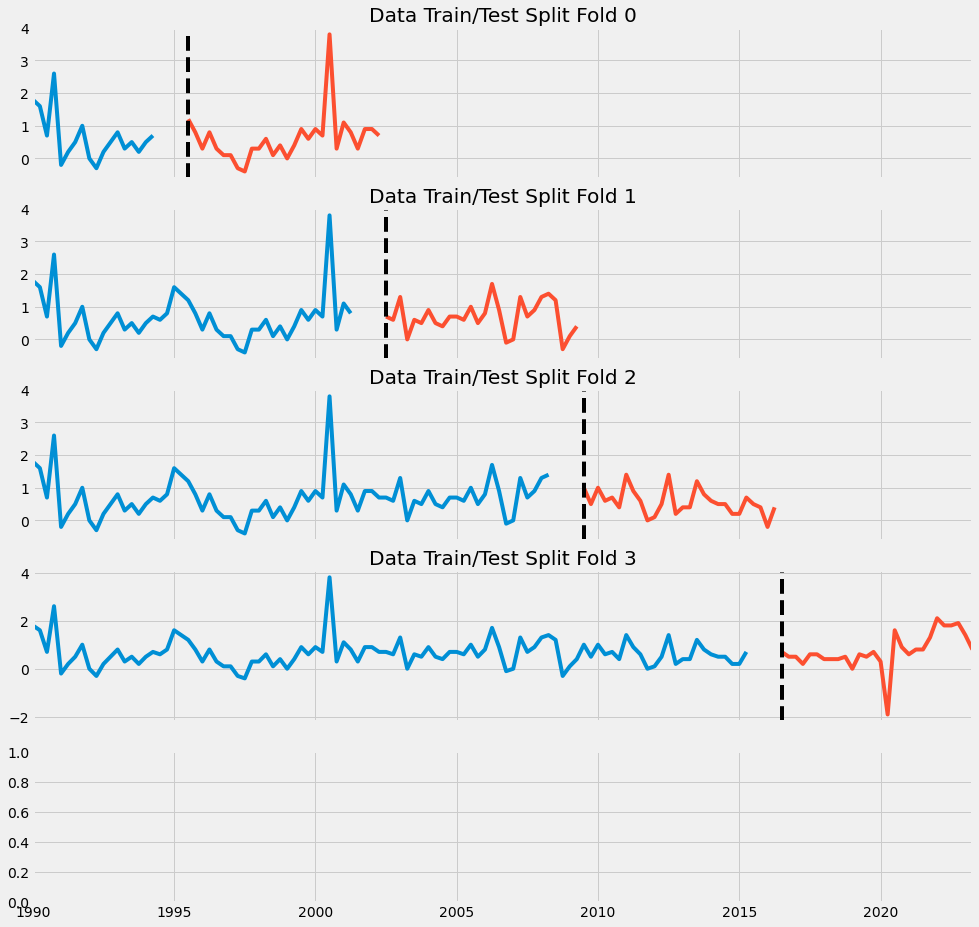

In [360]:
# Cross Validation using n-folds
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4, test_size=4*7, gap=4)
agcpi_df = agcpi_df.sort_index()

fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(agcpi_df):
    train = agcpi_df.iloc[train_idx]
    test = agcpi_df.iloc[val_idx]
    train['AGCPI'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['AGCPI'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

In [361]:
# Feature Creation 
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df

agcpi_df = create_features(agcpi_df)
agcpi_df.head()

,AGCPI,quarter,month,year
Quarter,,,,
1990-03-01,1.8,1,3,1990
1990-06-01,1.6,2,6,1990
1990-09-01,0.7,3,9,1990
1990-12-01,2.6,4,12,1990
1991-03-01,-0.2,1,3,1991


In [362]:
# Add time lags
def add_lags(df):
    target_map = df['AGCPI'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('365 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('1825 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('3650 days')).map(target_map)
    return df

agcpi_df = add_lags(agcpi_df)
agcpi_df.tail()

,AGCPI,quarter,month,year,lag1,lag2,lag3
Quarter,,,,,,,
2022-06-01,1.8,2,6,2022,0.8,NaN,NaN
2022-09-01,1.8,3,9,2022,0.8,NaN,NaN
2022-12-01,1.9,4,12,2022,1.3,NaN,NaN
2023-03-01,1.4,1,3,2023,2.1,NaN,NaN
2023-06-01,0.8,2,6,2023,1.8,NaN,NaN


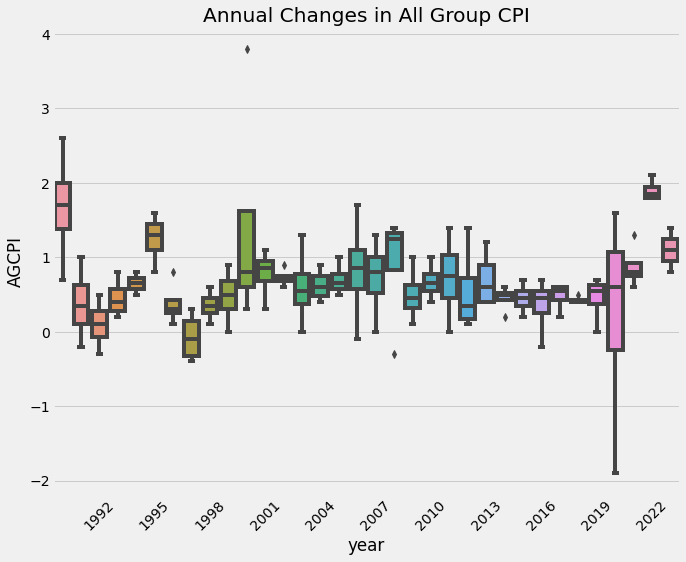

In [363]:
# Look at features on a yearly basis to see pattern 
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=agcpi_df, x='year', y='AGCPI')
ax.set_title('Annual Changes in All Group CPI')
# Set tick positions and labels manually
unique_years = sorted(agcpi_df['year'].unique())
xtick_positions = [i for i, year in enumerate(unique_years) if year % 3 == 0]
xtick_labels = [year for year in unique_years if year % 3 == 0]

ax.set_xticks(xtick_positions)
ax.set_xticklabels(xtick_labels, rotation=45)
plt.show()

[0]	validation_0-rmse:0.71919	validation_1-rmse:0.73715


/opt/homebrew/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:18:10] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[49]	validation_0-rmse:0.55887	validation_1-rmse:0.76555
[0]	validation_0-rmse:0.75396	validation_1-rmse:0.50899


/opt/homebrew/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:18:10] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[80]	validation_0-rmse:0.61043	validation_1-rmse:0.51742
[0]	validation_0-rmse:0.66357	validation_1-rmse:0.38641


/opt/homebrew/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:18:10] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[96]	validation_0-rmse:0.54892	validation_1-rmse:0.38196
[0]	validation_0-rmse:0.60684	validation_1-rmse:0.78515


/opt/homebrew/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:18:11] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.51398	validation_1-rmse:0.76819
[175]	validation_0-rmse:0.48317	validation_1-rmse:0.77662


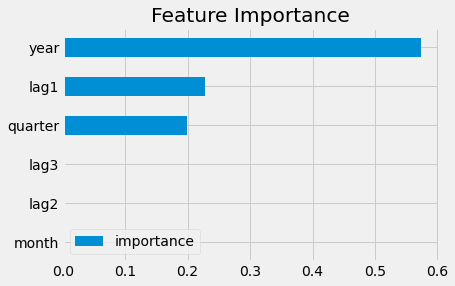

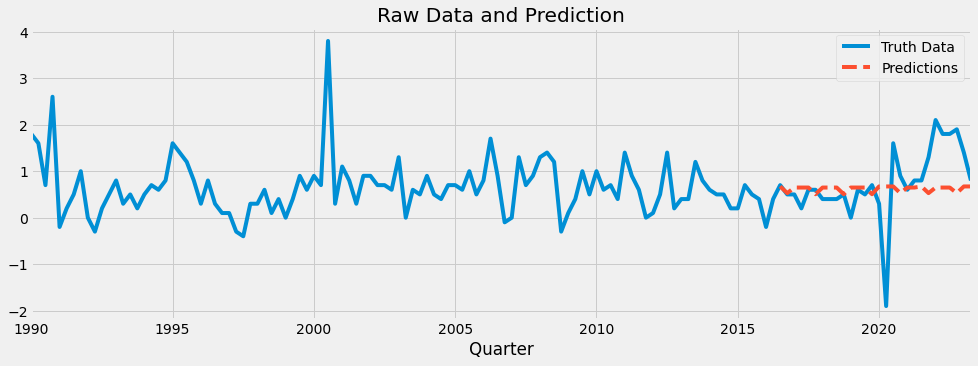

In [364]:
# create and run the XG Boost model

from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=4, test_size=4*7, gap=4)
agcpi_df = agcpi_df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(agcpi_df):
    train = agcpi_df.iloc[train_idx]
    test = agcpi_df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['quarter', 'month','year',
                'lag1','lag2','lag3']
    TARGET = 'AGCPI'

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

# Feature Importance
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

# Raw Data & Prediction
test['prediction'] = reg.predict(X_test)
agcpi_df = agcpi_df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = agcpi_df[['AGCPI']].plot(figsize=(15, 5))
agcpi_df['prediction'].plot(ax=ax, style='--')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [365]:
# Look at fold scores 
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 0.5868
Fold scores:[0.7371491439897327, 0.4679840786249939, 0.3750043669556376, 0.7672167001852643]


In [366]:
# Prediciting the future
# Retrain on all data
fnab_df = create_features(agcpi_df)

FEATURES = ['quarter', 'month', 'year',
            'lag1','lag2','lag3']
TARGET = 'AGCPI'

X_all = agcpi_df[FEATURES]
y_all = agcpi_df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.001)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:0.64371


/opt/homebrew/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [09:18:12] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:0.62958
[200]	validation_0-rmse:0.61729
[300]	validation_0-rmse:0.60657
[400]	validation_0-rmse:0.59720
[499]	validation_0-rmse:0.58908


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [367]:
# Create future dataframe
future = pd.date_range('2023-06-01','2033-06-01', freq='QS')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
agcpi_df['isFuture'] = False
agcpi_df_and_future = pd.concat([agcpi_df, future_df])
agcpi_df_and_future = create_features(agcpi_df_and_future)
agcpi_df_and_future = add_lags(agcpi_df_and_future)

agcpi_future_w_features = agcpi_df_and_future.query('isFuture').copy()

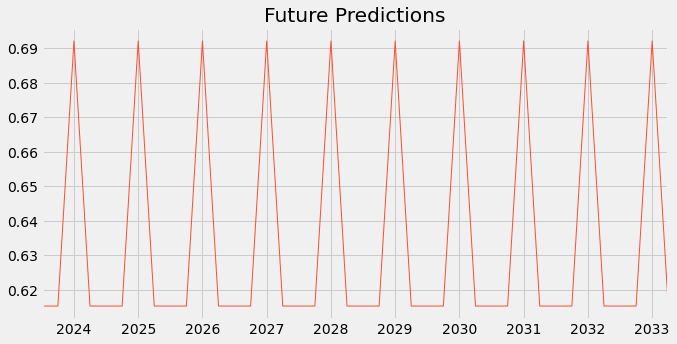

In [368]:
# Predict the future
agcpi_future_w_features['pred'] = reg.predict(agcpi_future_w_features[FEATURES])
agcpi_future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[1],
                               ms=1,
                               lw=1,
                               title='Future Predictions')
plt.show()